In [10]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import toml
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

import toml

import plotly.io as pio
from tqdm import tqdm
import seaborn as sns

pio.renderers.default = "vscode"

In [11]:
_base_dir = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), "..")),
    "recorded_data",
    "five_marker_validation",
)

settings = toml.load("calibration.toml")
_webcam_cam_mat = np.array(settings["calibration"]["camera_matrix"]).reshape((3, 3))
_webcam_dist = np.array(settings["calibration"]["dist_coeffs"]).reshape((1, 5))

_folder_list = os.listdir(_base_dir)[8:11]  # sideways

MOCAP data

In [12]:
m1 = get_rb_marker_name(2)
m4 = get_rb_marker_name(4)
m3 = get_rb_marker_name(3)
m5 = get_rb_marker_name(5)

Getting Sync pulse from Teensy

In [13]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [14]:
_folder_list

['speed_2', 'speed_3', 'speed_4']

In [15]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [16]:
results = {
    "ar_df": [],
    "ar_dt": [],
    "mc_xdf": [],
    "mc_dt": [],
    "time_offset": [],
    "vel_bins": [],
    "mc_df": [],
    "mc_xdf": [],
    "folder_name": [],
}
for _folder_name in _folder_list:
    ts_pth = os.path.join(
        os.path.join(_base_dir, _folder_name, "webcam_timestamp.msgpack")
    )
    with open(ts_pth, "rb") as ts_file:
        ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
        ts = list(ts_unpacker)

    _time = np.array(ts)[:, 1]
    _time = [datetime.strptime(_t, "%Y-%m-%d %H:%M:%S.%f") for _t in _time]
    _sync = np.array(ts)[:, 0].astype(bool)

    for idx, _s in enumerate(_sync):
        if _s:
            sync_start_idx = idx
            break

    _sync_index = _sync[sync_start_idx:]

    for idx, _s in enumerate(_sync_index):
        if not _s:
            sync_end_idx = idx
            break
    print(_sync)

    sync_end_idx = sync_start_idx + sync_end_idx

    sync_start_time = _time[sync_start_idx]
    sync_end_time = _time[sync_end_idx]

    # reading video
    _video = open(os.path.join(_base_dir, _folder_name, "webcam_color.msgpack"), "rb")
    _video_file = mp.Unpacker(_video, object_hook=mpn.decode)
    corners_data = list(_video_file)
    shape = corners_data[0]

    data = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}
    counter = 0

    for _frame in tqdm(corners_data[1:]):
        corners, ids = _frame

        if ids is None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(None)
            data["corners"].append(None)
            data["tvec"].append(None)
            data["rvec"].append(None)

        if ids is not None:
            rvec, tvec = estimatePoseSingleMarkers(
                corners=corners,
                marker_size=0.05,
                mtx=_webcam_cam_mat,
                distortion=_webcam_dist,
            )
            data["frame_id"].append(counter)
            data["marker_ids"].append(ids)
            data["corners"].append(corners)
            data["tvec"].append(tvec)
            data["rvec"].append(rvec)
        counter += 1

    # coordinates
    default_ids = [12, 14, 20, 88, 89]
    coordinate = {
        str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []}
        for id in default_ids
    }

    for i, frame_id in enumerate(data["frame_id"]):
        if data["marker_ids"][i] is not None:
            existing_ids = set(data["marker_ids"][i].reshape(-1))
            missing_ids = set(default_ids) - existing_ids

            for _m, tvec, rvec in zip(
                data["marker_ids"][i], data["tvec"][i], data["rvec"][i]
            ):
                if _m in default_ids:
                    coord = coordinate[str(_m[0])]
                    coord["x"].append(tvec[0][0])
                    coord["y"].append(tvec[0][1])
                    coord["z"].append(tvec[0][2])
                    coord["rx"].append(rvec[0][0])
                    coord["ry"].append(rvec[0][1])
                    coord["rz"].append(rvec[0][2])

            for _m in missing_ids:
                coord = coordinate[str(_m)]
                coord["x"].append(np.nan)
                coord["y"].append(np.nan)
                coord["z"].append(np.nan)
                coord["rx"].append(np.nan)
                coord["ry"].append(np.nan)
                coord["rz"].append(np.nan)
        else:
            for _m in default_ids:
                coord = coordinate[str(_m)]
                coord["x"].append(np.nan)
                coord["y"].append(np.nan)
                coord["z"].append(np.nan)
                coord["rx"].append(np.nan)
                coord["ry"].append(np.nan)
                coord["rz"].append(np.nan)

    # creating dataframe
    ar_df = pl.from_dict(coordinate["89"])
    ar_df = ar_df.insert_column(-1, pl.Series("time", _time))

    rvec = ar_df[["rx", "ry", "rz"]][0].to_numpy()

    ar_rotmat = cv2.Rodrigues(rvec)[0]

    tar = ar_rotmat.T @ (
        ar_df[["x", "y", "z"]].to_numpy().T - ar_df[["x", "y", "z"]][0].to_numpy().T
    )
    # _ar_df = pl.DataFrame({"time":ts,"x":tar[0], "y":tar[1], "z":tar[2], "rx":coordinate['89']["rx"], "ry":coordinate['89']["ry"], "rz":coordinate['89']["rz"]})
    _ar_df = pl.DataFrame({"time": _time, "x": tar[0], "y": tar[1], "z": tar[2]})

    _mocap_pth = os.path.join(
        os.path.abspath(os.path.join(os.getcwd(), "..")),
        "recorded_data",
        "five_marker_validation",
        "mocap",
        f"{_folder_name}.csv",
    )
    _mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
    _mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
    _mocap_df = pl.from_pandas(_mocap_df)

    cumulative = (
        _mocap_df[[m1["x"], m1["y"], m1["z"]]].to_numpy().T
        + _mocap_df[[m4["x"], m4["y"], m4["z"]]].to_numpy().T
        + _mocap_df[[m3["x"], m3["y"], m3["z"]]].to_numpy().T
        + _mocap_df[[m5["x"], m5["y"], m5["z"]]].to_numpy().T
    )
    cumulative = cumulative / 4

    _m_df = pl.DataFrame(
        {
            "time": _mocap_df["time"],
            "x": cumulative[0],
            "y": cumulative[1],
            "z": cumulative[2],
        }
    )

    _mc_org = _mocap_df[[m3["x"], m3["y"], m3["z"]]][0].to_numpy().T
    _mc_xvec = _mocap_df[[m5["x"], m5["y"], m5["z"]]][0].to_numpy().T
    _mc_yvec = _mocap_df[[m1["x"], m1["y"], m1["z"]]][0].to_numpy().T

    _mc_rotmat = calculate_rotmat_from_xyo(_mc_xvec, _mc_yvec, _mc_org)

    tmc = _mc_rotmat.T @ (
        _m_df[["x", "y", "z"]].to_numpy().T - _m_df[["x", "y", "z"]][0].to_numpy().T
    )
    _mc_df = pl.DataFrame(
        {"time": _mocap_df["time"], "x": tmc[0], "y": tmc[1], "z": tmc[2]}
    )

    # velocity_cuts = np.nanmax(abs(_mc_df['x'].diff()/0.01))/12
    velocity_cuts = 0.6 / 12
    _vel_bins = []
    for i in range(12):
        _vel_bins.append((i) * velocity_cuts)

    bin_idx = np.digitize(abs(_mc_df["x"].diff() / 0.01), bins=_vel_bins, right=True)
    bin_df = pl.Series("bin", bin_idx)
    _mc_df.insert_column(4, bin_df)
    _mc_df.group_by("bin", maintain_order=True).count()

    # _time_offset = ar_df['time'][idx] - ar_df['time'][0]

    # interpolate teensy data to match aruco data

    ar_df = ar_df[sync_start_idx:sync_end_idx]
    _new_time = _time[sync_start_idx:sync_end_idx]
    _ar_df_test = ar_df.clone()
    _ar_df_test = _ar_df_test[sync_start_idx:sync_end_idx]

    _data_time_offset = _new_time[0] - _mocap_df["time"][0]
    _ar_df_test = _ar_df_test.with_columns(
        [(pl.col("time") - _data_time_offset).alias("time")]
    )
    _ar_df = _ar_df_test

    ar_time = _ar_df["time"].dt.epoch()
    ar_time = ar_time - ar_time[0]
    ar_time = [timedelta(microseconds=t).total_seconds() for t in ar_time]
    ar_time = np.array(ar_time)

    mc_time = _mocap_df["time"].dt.epoch()
    mc_time = mc_time - mc_time[0]
    mc_time = [timedelta(microseconds=t).total_seconds() for t in mc_time]
    mc_time = np.array(mc_time)

    ar_del_t = _ar_df["time"].diff().mean() / 10**6
    mc_del_t = 0.01

    f = interp1d(
        _mc_df["time"].dt.epoch(), _mc_df["x"], kind="linear", fill_value="extrapolate"
    )  # You can also use 'cubic' or other interpolation methods
    _mc_x = f(_ar_df["time"].dt.epoch())
    _mc_xdf = pl.DataFrame({"time": _ar_df["time"], "x": _mc_x})

    bin_idx = np.digitize(
        abs(_mc_xdf["x"].diff() / ar_del_t), bins=_vel_bins, right=True
    )
    bin_df = pl.Series("bin", bin_idx)
    _mc_xdf.insert_column(2, bin_df)
    _ar_df.insert_column(len(_ar_df.columns), bin_df)

    results["ar_df"].append(_ar_df)
    results["ar_dt"].append(ar_del_t)
    results["mc_xdf"].append(_mc_xdf)
    results["mc_dt"].append(mc_del_t)
    results["time_offset"].append(0)
    results["vel_bins"].append(_vel_bins)
    results["mc_df"].append(_mc_df)
    results["mc_xdf"].append(_mc_xdf)
    results["folder_name"].append(_folder_name)

[False False False ... False False False]


100%|██████████| 5370/5370 [00:01<00:00, 3862.11it/s]
e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

C:\Users\Pintu\AppData\Local\Temp\ipykernel_67364\2621854777.py:181: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



[False False False ... False False False]


100%|██████████| 5567/5567 [00:01<00:00, 3893.96it/s]
e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

C:\Users\Pintu\AppData\Local\Temp\ipykernel_67364\2621854777.py:181: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



[False False False ... False False False]


100%|██████████| 5797/5797 [00:01<00:00, 3014.55it/s]
e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

C:\Users\Pintu\AppData\Local\Temp\ipykernel_67364\2621854777.py:181: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



In [17]:
histograms = []

In [18]:
missing_percent_one = []
missing_percent_all = []

for j in range(len(results["ar_df"])):
    for i in range(
        len(
            results["ar_df"][0]
            .group_by("bin", maintain_order=False)
            .agg(pl.col("x"))["x"]
        )
    ):
        missing_percent_one.append(
            1
            - results["ar_df"][j]
            .group_by("bin", maintain_order=False)
            .agg(pl.col("x"))["x"][i]
            .is_nan()
            .sum()
            / len(
                results["ar_df"][j]
                .group_by("bin", maintain_order=False)
                .agg(pl.col("x"))["x"][i]
            )
        )
    missing_percent_one = np.array(missing_percent_one) * 100
    missing_percent_all.append(missing_percent_one)
    missing_percent_one = []

In [21]:
bin_numbers = ["1", "2", "3", "4", "5", "6", "7"]
missing_percentage = []
for i in bin_numbers:
    missing_percentage.append(
        _ar_df["x"][bins_idx[i]].is_nan().sum() / len(_ar_df["x"][bins_idx[i]])
    )

[shape: (4_560, 8)
 ┌───────────┬──────────┬──────────┬───────────┬───────────┬─────────────────┬───────────┬─────┐
 │ x         ┆ y        ┆ z        ┆ rx        ┆ ry        ┆ time            ┆ rz        ┆ bin │
 │ ---       ┆ ---      ┆ ---      ┆ ---       ┆ ---       ┆ ---             ┆ ---       ┆ --- │
 │ f64       ┆ f64      ┆ f64      ┆ f64       ┆ f64       ┆ datetime[μs]    ┆ f64       ┆ i64 │
 ╞═══════════╪══════════╪══════════╪═══════════╪═══════════╪═════════════════╪═══════════╪═════╡
 │ 0.001266  ┆ 0.041125 ┆ 0.451372 ┆ 3.019953  ┆ 0.040987  ┆ 2024-07-20      ┆ -0.244147 ┆ 12  │
 │           ┆          ┆          ┆           ┆           ┆ 16:01:31.045814 ┆           ┆     │
 │ 0.001559  ┆ 0.041081 ┆ 0.453256 ┆ 2.971865  ┆ 0.03929   ┆ 2024-07-20      ┆ -0.082952 ┆ 12  │
 │           ┆          ┆          ┆           ┆           ┆ 16:01:31.063630 ┆           ┆     │
 │ 0.001559  ┆ 0.041081 ┆ 0.453256 ┆ 2.971865  ┆ 0.03929   ┆ 2024-07-20      ┆ -0.082952 ┆ 12  │
 │         

In [19]:
missing_percent_all

[array([91.88596491]), array([90.42735043]), array([87.84200782])]

In [20]:
cols = []
for i in np.array(_vel_bins):
    cols.append(f"{i:.2f}")

per_df = pl.DataFrame(np.array(missing_percent_all))
per_df.columns = cols

ShapeError: 12 column names provided for a DataFrame of width 1

In [ ]:
per_df

column_0
f64
91.885965
90.42735
87.842008


Text(0, 0.5, 'Percentage of detection (%)')

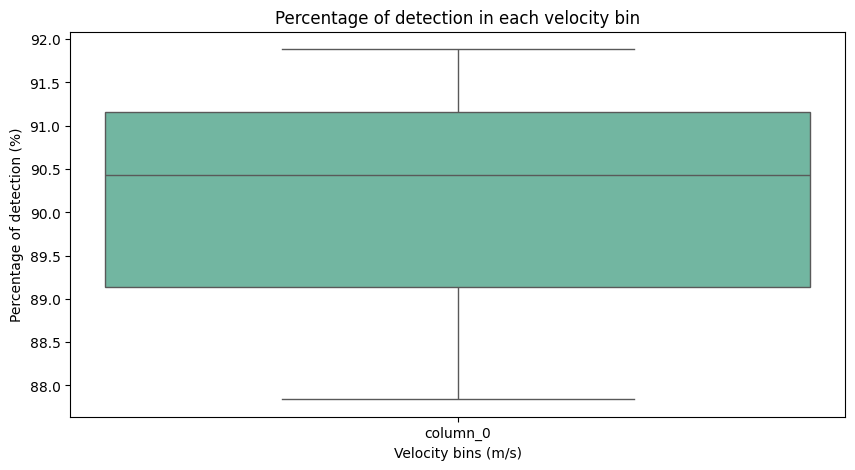

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=per_df.to_pandas(), palette="Set2")
sns.lineplot(x=per_df.to_pandas().columns, y=per_df.to_pandas().median())
plt.title("Percentage of detection in each velocity bin")
plt.xlabel("Velocity bins (m/s)")
plt.ylabel("Percentage of detection (%)")

# sns.violinplot(data=per_df.to_pandas(), palette="Set2")

In [ ]:
per_df.write_csv("./data_csv/percentage_detection_ar.csv")